In [1]:
from thllib import flylib as flb
from matplotlib import pyplot as plt
import numpy as np
import scipy
from thllib import util
import figurefirst as fifi
from scipy import signal

In [2]:
%matplotlib inline

In [3]:
flynumbers = list(range(1389,1402))

In [4]:
flylist = [flb.NetFly(fnum,rootpath='/media/imager/FlyDataD/FlyDB/') for fnum in flynumbers]

In [5]:
fly = flylist[4]
fly.open_signals()

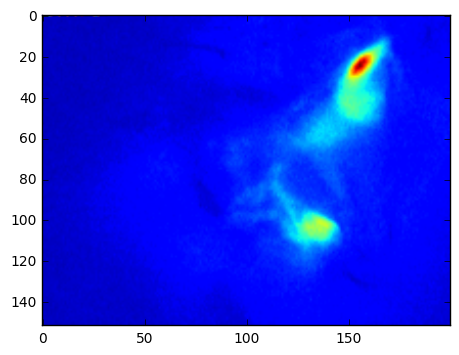

In [16]:
tidx = 1000
plt.imshow(fly.ca_cam_right[tidx])

In [10]:
import h5py
unmixing_filters = '/media/imager/FlyDataD/src/muscle_model/unmixing_filters/NA_0.45_200mm_Tube_FN1/flatened_model.hdf5'
model_data = h5py.File(unmixing_filters,'r')

import muscle_model as mm
import cv2

confocal_model = mm.GeometricModel(filepath = '/media/imager/FlyDataD/src/planotaxis/models/thorax/outlines.cpkl')

fly_frame = mm.Frame()
fly_frame.load(fly.flypath + '/' + 'ca_cam_right_rframe_fits.cpkl')
A = fly_frame.get_transform(confocal_model.frame)
s = 1
Ap = np.dot([[s,0.0,0],[0,s,0],[0,0,1]],A)

muscles = fly.ca_cam_left_model_fits.keys()
muscles.remove('bkg')
model_muscles = np.array([np.array(model_data[muscle]) for muscle in muscles])

bkg = fly.ca_cam_right[0]
output_shape = np.shape(bkg)

In [25]:
right_ca_dict = {}
right_impulse_dict = {}

In [26]:
for muscle in muscles:
    right_ca_dict[muscle] = np.zeros_like(fly.ca_cam_right_model_fits[muscle])
    right_impulse_dict[muscle] = np.zeros_like(fly.ca_cam_right_model_fits[muscle])

In [ ]:
def forward_optimize(time                    
                     ca_dict,
                     impulse_dict,
                     kernel,
                     kernel_window_s = 2,
                     kernel_gain = 0.05):
    kernel = kernel*kernel_gain
    #recon = np.zeros_like(resample_times)
    #impulses = np.zeros_like(resample_times)
    rate = times[1]-times[0]
    kernel_window_idx = np.int(kernel_window_s*resample_rate)
    max_idx = len(times)
    end_first_loop = times[-1] - kernel_window_s
    last_imp = np.argwhere(impulse_idxs < end_first_loop)[-1][0]
    for imp_idx,nxt_idx in zip(impulse_idxs[:last_imp],impulse_idxs[1:last_imp+1]):
        imp_window = impulses[imp_idx:imp_idx+kernel_window_idx]
        n1 = np.linalg.norm(recon[imp_idx:nxt_idx]-resampled_ca[imp_idx:nxt_idx])
        recon[imp_idx:imp_idx+kernel_window_idx] += kernel[:kernel_window_idx]
        n2 = np.linalg.norm(recon[imp_idx:nxt_idx] - resampled_ca[imp_idx:nxt_idx])
        if n2>n1:
            recon[imp_idx:imp_idx+kernel_window_idx] -= kernel[:kernel_window_idx]
        else:
            impulses[imp_idx] = 1
    #finish up - bit slower
    for imp_idx,nxt_idx in zip(impulse_idxs[last_imp:-2],impulse_idxs[last_imp+1:-1]):
        kw = max_idx-imp_idx
        imp_window = impulses[imp_idx:imp_idx+kw]
        n1 = np.linalg.norm(recon[imp_idx:nxt_idx]-resampled_ca[imp_idx:nxt_idx])
        recon[imp_idx:imp_idx+kw] += kernel[:kw]
        n2 = np.linalg.norm(recon[imp_idx:nxt_idx] - resampled_ca[imp_idx:nxt_idx])
        if n2>n1:
            recon[imp_idx:imp_idx+kw] -= kernel[:kw]
        else:
            impulses[imp_idx] = 1
    return recon,impulses

In [14]:
sample = np.array([fly.ca_cam_right_model_fits[k][tidx] for k in muscles])
img = np.sum(model_muscles*sample[:,None,None],axis = 0)
X_warped = cv2.warpAffine(img,A[:-1,:],output_shape).T + 2*bkg

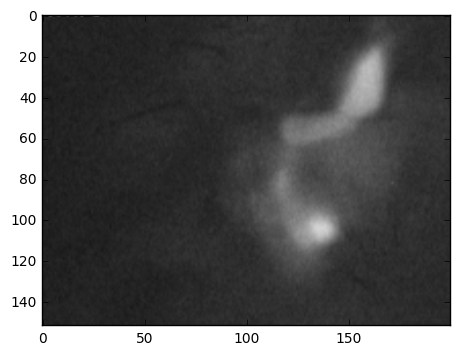

In [19]:
plt.imshow(X_warped,cmap = plt.cm.gray)